# Part 2 - Listening Habits and Type of music

In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We start by importing data from the pickle object that we saved then we transform the date format.

In [383]:
df = pd.read_pickle('data/all_data.pkl')
df['date']=pd.to_datetime(df['date'], format='%d %b %Y, %H:%M')
df.head(5)

,album,album_mbid,artist,artist_mbid,date,date_uts,name,url
0,British Mind,NaN,Hinds,NaN,2018-11-25 19:37:00,1543174671,British Mind,https://www.last.fm/music/Hinds/_/British+Mind
1,Cocoa Sugar,NaN,Young Fathers,24aa5c20-a275-468a-93a9-b3d96b344b6c,2018-11-25 19:15:00,1543173342,Border Girl,https://www.last.fm/music/Young+Fathers/_/Bord...
2,Cocoa Sugar,NaN,Young Fathers,24aa5c20-a275-468a-93a9-b3d96b344b6c,2018-11-25 19:12:00,1543173150,In My View,https://www.last.fm/music/Young+Fathers/_/In+M...
3,White Men Are Black Men Too,NaN,Young Fathers,24aa5c20-a275-468a-93a9-b3d96b344b6c,2018-11-25 18:47:00,1543171669,Shame,https://www.last.fm/music/Young+Fathers/_/Shame
4,Toy,NaN,Young Fathers,24aa5c20-a275-468a-93a9-b3d96b344b6c,2018-11-25 18:43:00,1543171390,Toy,https://www.last.fm/music/Young+Fathers/_/Toy


### Listening Habits

#### Evolution of how much I listen to music since October 2012

In [177]:
scrobbles_by_date= df.set_index('date').groupby(pd.TimeGrouper('M'))['name'].agg([('count')])

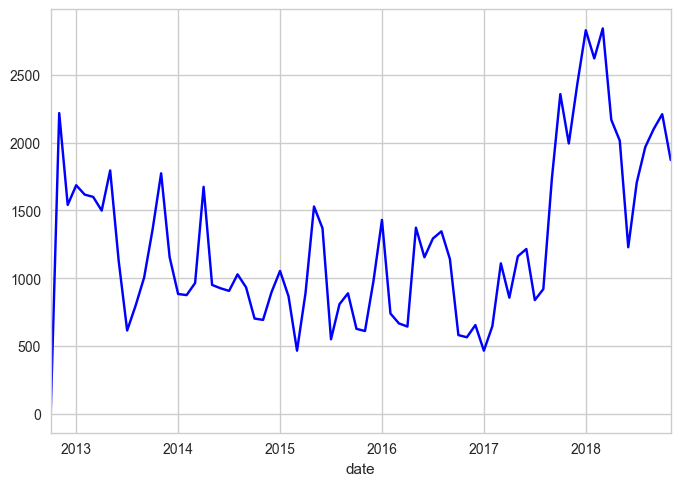

In [180]:
scrobbles_by_date['count'].plot(color='blue')
plt.show()

Since the middle 2017, the amount of music I listen to has increased because I started attending a lot of concerts. (Gotta prepare for the gig ya know)

Now let's plot it using a cumsum

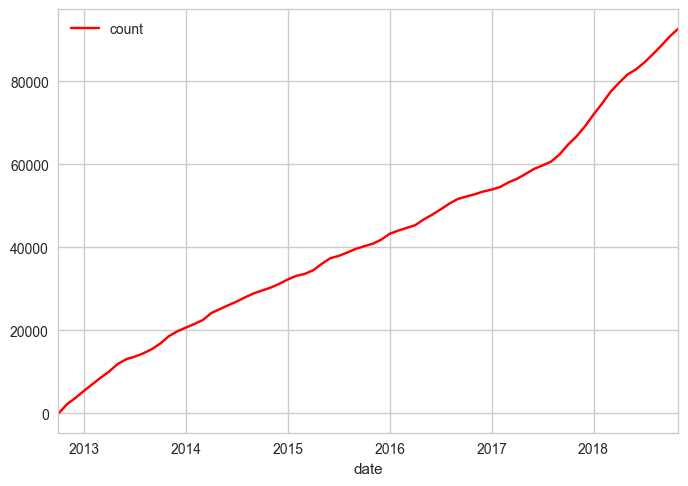

In [203]:
scrobbles_by_date.cumsum().plot(color='red')
plt.show()

#### When do I listen to data ? 

###### Which hour of the day do I listen to music?

In [181]:
scrobbles_by_hour= df.groupby(df.set_index('date').index.hour)['name'].agg([('count')]).reset_index()

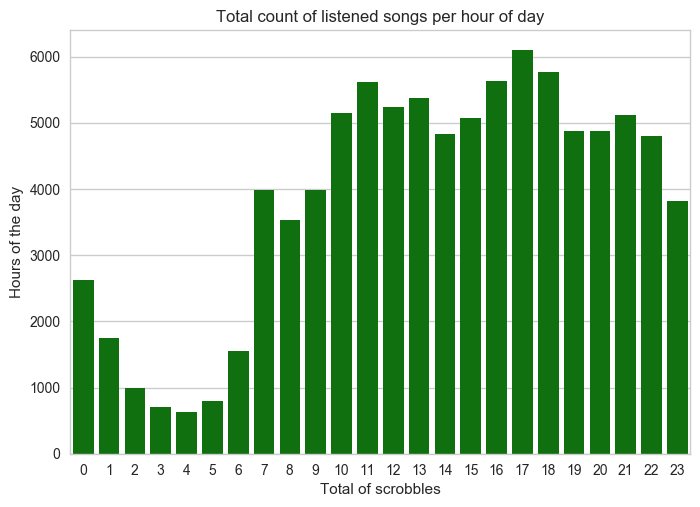

In [182]:
sns.set(style="whitegrid")
ax = sns.barplot(x="index", y="count", data=scrobbles_by_hour, color='green')
ax.set(ylabel="Hours of the day", xlabel="Total of scrobbles")
ax.set_title('Total count of listened songs per hour of day')
plt.show()

###### Which day of the week do I listen to music ?

In [183]:
def index_to_day(argument):
    switcher = {
        0: "Monday",
        1: "Tuesday",
        2: "Wednesday",
        3: "Thursday",
        4: "Friday",
        5: "Saturday",
        6: "Sunday"
    }
    return switcher.get(argument, "duh")

In [184]:
scrobbles_by_dayofweek = df.groupby(df.set_index('date').index.dayofweek)['name'].agg([('count')]).reset_index()
scrobbles_by_dayofweek['index'] = scrobbles_by_dayofweek['index'].apply(index_to_day)

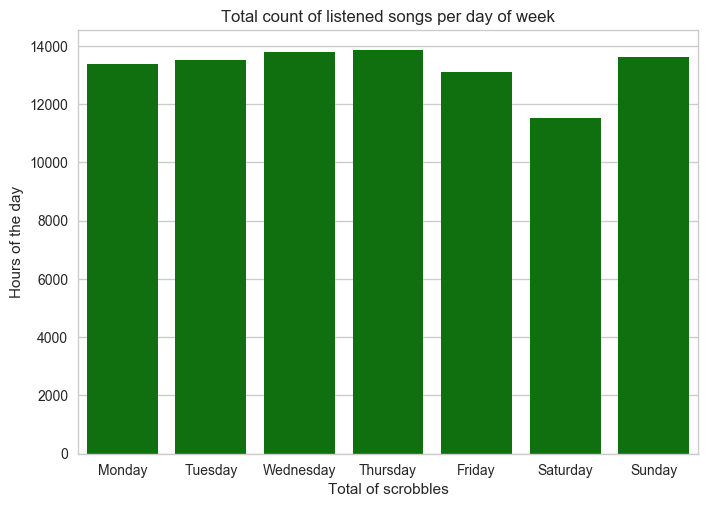

In [185]:
sns.set(style="whitegrid")
ax = sns.barplot(x="index", y="count", data=scrobbles_by_dayofweek, color='green')
ax.set(ylabel="Hours of the day", xlabel="Total of scrobbles")
ax.set_title('Total count of listened songs per day of week')
plt.show()

Now let's see how my listening habits have changed once I started working. We'll filter data from February 2017.

In [230]:
df_201702=df[df.date>'2017-02-01'].copy()
scrob_by_dow_and_h=df_201702.groupby([df_201702.set_index('date').index.dayofweek,df_201702.set_index('date').index.hour])['name'].agg([('count')]).reset_index()
scrob_by_dow_and_h.columns = ['dayofweek', 'hour','count']
scrob_by_dow_and_h['dayofweek'] = scrob_by_dow_and_h['dayofweek'].apply(index_to_day)
scrob_by_dow_and_h=pd.pivot_table(scrob_by_dow_and_h, values = 'count', index=['hour'], columns = 'dayofweek').reset_index()
scrob_by_dow_and_h=scrob_by_dow_and_h[['hour','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]

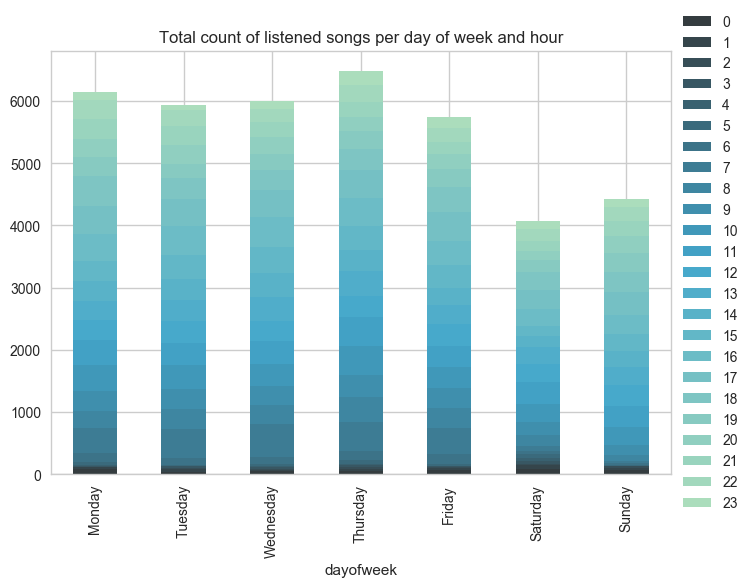

In [231]:
from matplotlib.colors import ListedColormap

sns.set(style="whitegrid")
scrob_by_dow_and_h.set_index('hour').T.plot(kind='bar', stacked=True,colormap=ListedColormap(sns.color_palette("GnBu_d", 24)))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Total count of listened songs per day of week and hour')

plt.show()

I listen less to music on weekends now because I go out. Also, there's an interesting trend on how I listen to music on friday and saturday late at night. Mostly using my phone to listen to music somewhere with friends.

### What type of music do I listen to ? 

To answer this question, we're gonna start by getting the distinct artists I listened to and then get artists tags from Last FM.

We'll get the top 5 tags (if found) from each artist and we'll use the first tag. Tags are voted by LastFM users.

TODO : Try to get info from the 5 tags, some artists for example can be Indie Rock, Post-Punk and Punk, but right now some types may be forgotten because they don't alyways appear as the first tag.

##### Get tags from Last FM

In [384]:
import requests 
import numpy as np
import time

#Enter Username to scrap
username='saadadr'

#Enter API credentials
api_key='##################"'

In [385]:
df_artists= pd.DataFrame()
df_artists['artist']= df['artist'].copy().unique()

Counting the unique artists.

In [386]:
df_artists.count()

artist    3604
dtype: int64

In [387]:
df_artists['tag1'] = None
df_artists['tag2'] = None
df_artists['tag3'] = None
df_artists['tag4'] = None
df_artists['tag5'] = None

This following function gets an artists name (and api key) and returns the info retrieved from the LastFM API.

In [388]:
def get_artist_top_tags(artist,api_key):
    link='http://ws.audioscrobbler.com/2.0/'
    params={'method':'artist.gettoptags',
        'artist':artist,
        'api_key':api_key,
        'format':'json'}
    return requests.get(link,params).json()

We scrap the returned JSON to to extract the different tags.

In [390]:
i=0
n=str(df_artists.count()[0])
for artist in df_artists['artist']:
    #print artist
    if i%50==0:
        print "scrapped "+str(i)+" out of "+n+'.'
    tags=get_artist_top_tags(artist,api_key)
    list_tags=[]
    #get 6 first tag and remove the seen live tag if it exists because it's not intersting for us
    for tag in tags['toptags']['tag'][:6]:
        list_tags.append(tag['name'])
    if 'seen live' in list_tags:
        list_tags.pop(list_tags.index('seen live'))
    tagnb=1
    for tag in list_tags[:5]:
        tagnb_str='tag'+str(tagnb)
        #print tagnb_str
        df_artists.loc[df_artists.artist==artist,tagnb_str]=tag.lower()
        tagnb=tagnb+1
    
    i=i+1

scrapped 0 out of 3604.
scrapped 50 out of 3604.
scrapped 100 out of 3604.
scrapped 150 out of 3604.
scrapped 200 out of 3604.
scrapped 250 out of 3604.
scrapped 300 out of 3604.
scrapped 350 out of 3604.
scrapped 400 out of 3604.
scrapped 450 out of 3604.
scrapped 500 out of 3604.
scrapped 550 out of 3604.
scrapped 600 out of 3604.
scrapped 650 out of 3604.
scrapped 700 out of 3604.
scrapped 750 out of 3604.
scrapped 800 out of 3604.
scrapped 850 out of 3604.
scrapped 900 out of 3604.
scrapped 950 out of 3604.
scrapped 1000 out of 3604.
scrapped 1050 out of 3604.
scrapped 1100 out of 3604.
scrapped 1150 out of 3604.
scrapped 1200 out of 3604.
scrapped 1250 out of 3604.
scrapped 1300 out of 3604.
scrapped 1350 out of 3604.
scrapped 1400 out of 3604.
scrapped 1450 out of 3604.
scrapped 1500 out of 3604.
scrapped 1550 out of 3604.
scrapped 1600 out of 3604.
scrapped 1650 out of 3604.
scrapped 1700 out of 3604.
scrapped 1750 out of 3604.
scrapped 1800 out of 3604.
scrapped 1850 out of 360

In [391]:
#we save the results to pickle
df_artists.to_pickle('data/df_artists.pkl')

We merge artists data and the first scraped tag with the scrobbles data.

In [392]:
df=pd.merge(df, df_artists[['artist','tag1']], on='artist', how='left')

In [393]:
def plot_top(attrib, title,label):
    sns.set(style="whitegrid")
    f, ax = plt.subplots()

    group  = df.groupby(attrib)['name'].agg([('count')]).reset_index().sort_values('count', ascending=False ).head(15)


    sns.set_color_codes("bright")
    sns.barplot(x="count", y=attrib, data=group,
                label=label, color="green")


    # Add a legend and informative axis label
    ax.legend( ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel="", xlabel="")
    ax.set_title(title)
    
    plt.show()

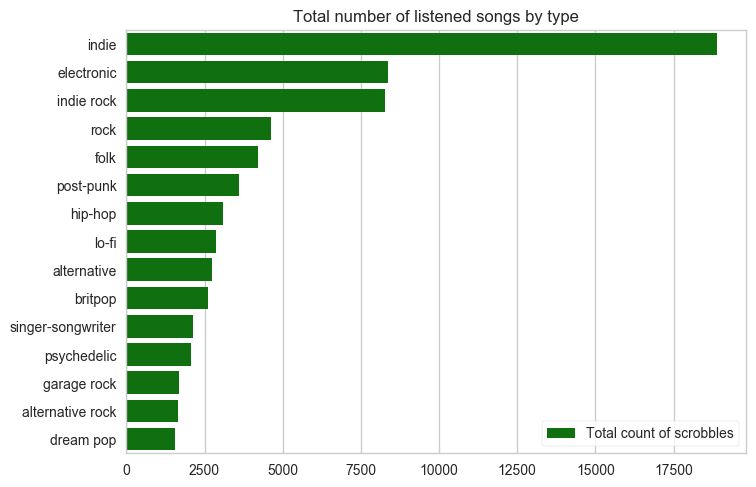

In [394]:
plot_top('tag1', 'Total number of listened songs by type','Total count of scrobbles')

##### I'm an indiehead, that's no suprise. But how did my music styles evolved ?

We'll study the evolution of the top 10 different styles.

In [395]:
styles = ['indie','electronic','indie rock','rock','folk','post-punk','hip-hop','lo-fi','alternative','britpop']

In [396]:
df_styles_evol = df.set_index('date').groupby([pd.TimeGrouper('M'),'tag1'])['name'].agg([('count')])
df_styles_evol=df_styles_evol[np.in1d(df_styles_evol.index.get_level_values(1),styles)]
df_styles_evol= df_styles_evol.reset_index().set_index('date')
df_styles_evol['cumsum']=df_styles_evol_2.groupby(['tag1'])['count'].cumsum()
df_styles_evol=df_styles_evol.reset_index()

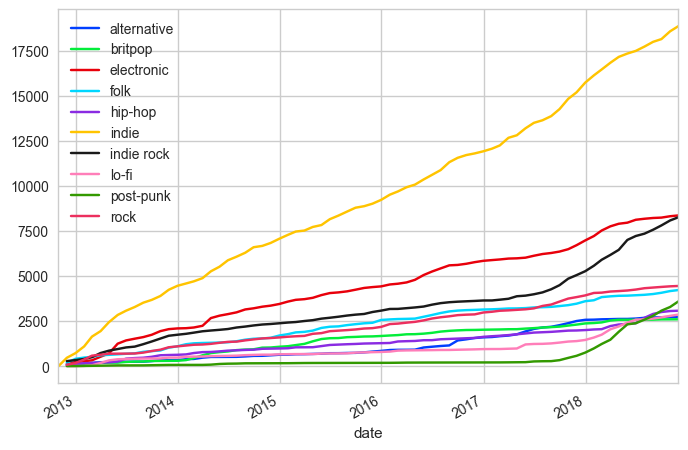

In [397]:
fig, ax = plt.subplots()
i=0
colors = ['b','g','r','c','m','y','k','#FF7EB9','#339900','#EC2F5E']
          
for key, grp in df_styles_evol.groupby(['tag1']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='cumsum',c=colors[i], label=key)
    i+=1
    
plt.legend(loc='best')
plt.show()

Looks like I've started listening to a lot of post-punk, indie rock as defined and lo-fi since mid-2017. Another interesting result is that the electronic and rock styles have been stagnating since 2016, sad!